# Data Management Project

We have decided to work on the topic subject: *"Movie Reviews and their relation to the ratings on IMDB"*.
The question we ask ourselves and look to answer is more precisely: can IMDb ratings be predicted from reviews? Additionally, we want to see if that relationship is improved when adding other components such as metadata and reviewer information, as to know if the text alone is sufficient or not.

In order to do so, we use two datasets that we merge together based on the title. Several graphs are made to observe the relationship between several variables and ratings. Finally, we look at several models to determine which model predicts the relationship the best.

## Step 1 : Data Cleaning & Collection

We begin by importing all the librairies needed for the project. Afterwards we define the functions we will need in order to merge the databases based on the column containing the titles of the movies. We identify potential issues such as missing values, doubles, punctuations, etc. We start with the data on the reviews, and then the metadata.


In [1]:
# we needed to install those first since we did not have them

# import sys
# !{sys.executable} -m pip install unidecode
# !{sys.executable} -m pip install textblob

In [1]:
# imports needed for data cleaning

import polars as pl
from glob import glob
import pandas as pd
from unidecode import unidecode
import string

import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from datetime import datetime
from sklearn.model_selection import train_test_split


# added libraries for graph

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


# needed libraries for ML and NLP

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer

In order to merge the review database with the movie metadata, we must ensure that the movie titles match perfectly. Therefore, we will apply two cleaning steps:

1. Extract the exact title by removing parentheses at the end*
2. Normalize the title: we converted titles to lowercase, removed the accents and any special characters, such as punctuation marks.

*We strip what is inside of the parentheses after a title so that we can preserve titles that are themselves years (e.g. '1917') and get rid of the years inside parentheses to facilitate the merge. Indeed, the IMDb format for titles is often presented as "Title (Year)".

In [3]:
# to remove anything that is in parentheses at the end of the title
def extract_title(title):
    if title is None:
        return None
    title = title.split(" (")[0].strip()
    return title

In [4]:
# normalize titles to merge later on

def normalize_title(t):
    if not isinstance(t, str):  # ignore non-string
        return None
    
    t = unidecode(t.lower())
    t = t.replace("-", " ").replace(":", " ")
    
    for p in string.punctuation:
        t = t.replace(p, "")

    t = " ".join(t.split())
    
    return t

### Loading and Concatenating the Review Data
The review data is stored across multiple parts of JSON files. All files are read and concatenated into a single Polars Dataframe. It has been determined better and more optimized to use Polars instead of Pandas at first because it reads the data faster and in a more efficient way. When using Pandas, the process was much longer due to the content of the .json files.

In [5]:
# read all json files
files = glob("./archive/*.json")
dfs = [pl.read_json(f) for f in files]
reviews = pl.concat(dfs)

In [6]:
print("Reviews shape :", reviews.shape)

Reviews shape : (5671499, 9)


### Cleaning and Normalizing the Movie Titles
We apply the previously defined title-cleaning functions directly within Polars. Parentheses are removed and tiltes are normalized.

In [7]:
# apply to Polars to handle the massive amount of data the files contain

reviews = reviews.with_columns(
    pl.col("movie").map_elements(extract_title, return_dtype=pl.Utf8).alias("clean_title")
)

reviews = reviews.with_columns(
    pl.col("clean_title").map_elements(normalize_title, return_dtype=pl.Utf8).alias("title_norm")
)

### Loading the Movie Metadata

The movie metadata and ratings are loaded from the TSV files using Pandas.

In [8]:
# read metadata with Pandas first then convert to Polars --> Polars doesn't handle quotes, accents, etc. well, so we have to use Pandas
basics = pd.read_csv("title.basics.tsv", sep="\t", dtype=str, na_values="\\N", low_memory=False, encoding="utf-8")
ratings = pd.read_csv("title.ratings.tsv", sep="\t", dtype=str, na_values="\\N", low_memory=False, encoding="utf-8")

print("Basics :", basics.shape)
print("Ratings:", ratings.shape)


Basics : (12194325, 9)
Ratings: (1618818, 3)


### Merging Movie Metadata with the Review Data
The metadata tables are merged on the IMDb identifier (tconst). In order to ensure compatibility with the cleaned review titles, we will apply the same normalization function to the movie titles in the metadata.

In [9]:
# normalize title for metadata
metadata = basics.merge(ratings, on="tconst", how="left")

metadata["title_norm"] = metadata["primaryTitle"].apply(normalize_title)

For performance reasons, the merged metadata is converted to Polars and we will restrict the database so that it will only contain the relevant columns for the analysis. Only entries corresponding to movies are kept in the metadata database.

In [10]:
# convert to Polars to make it quicker
metadata_pl = pl.from_pandas(metadata)

In [11]:
print(metadata_pl.columns)

['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes', 'title_norm']


In [12]:
metadata_small = metadata_pl.select(["tconst", "titleType", "primaryTitle", "title_norm", "startYear", "runtimeMinutes", "genres", "averageRating", "numVotes"])

In [13]:
metadata_small = metadata_small.filter(pl.col("titleType") == "movie")

### Merging the Reviews and Metadata

The review dataset is merged with the movie metadata using the normalized title as the key. We will be using a left join to preserve all reviews, allowing unmatched titles to be identified.

In [14]:
merged_full = (reviews.lazy().join(metadata_small.lazy(), on="title_norm", how="left").collect())

print("Full merged shape :", merged_full.shape)
print("Missing matches :", merged_full.filter(pl.col("tconst").is_null()).shape)

Full merged shape : (14388075, 19)
Missing matches : (1481779, 19)


### Filtering, Sampling and Exporting the final Database.

Reviews without matching metadata are removed.
We are taking a sample of 500000 reviews out of the millions of reviews that we have in the original database.

In [15]:
merged = merged_full.filter(pl.col("tconst").is_not_null())

In [16]:
sample = merged.sample(n=500_000, shuffle=True)

In [17]:
print("Sample shape:", sample.shape)
print("Missing matches:", sample.filter(pl.col("tconst").is_null()).shape)

Sample shape: (500000, 19)
Missing matches: (0, 19)


In [18]:
print(sample.dtypes)

[String, String, String, String, String, String, Int64, String, List(String), String, String, String, String, String, String, String, String, String, String]


In [19]:
# seeing that we have a column in the list type, we want to identify it because it could cause problems when doing the graphs

for col, dtype in zip(sample.columns, sample.dtypes):
    if isinstance(dtype, pl.List):
        print(col, dtype)

helpful List(String)


In [20]:
print(sample.columns)

['review_id', 'reviewer', 'movie', 'rating', 'review_summary', 'review_date', 'spoiler_tag', 'review_detail', 'helpful', 'clean_title', 'title_norm', 'tconst', 'titleType', 'primaryTitle', 'startYear', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes']


In [21]:
sample = sample.drop(["helpful", "spoiler_tag"])

In [22]:
sample.write_csv("imdb_reviews_500k.csv")

In [23]:
sample.head(5)

review_id,reviewer,movie,rating,review_summary,review_date,review_detail,clean_title,title_norm,tconst,titleType,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""rw2120619""","""lmsnowhte""","""Buddy (1997)""",null,"""Help! to find Gorilla Movie Na…","""1 September 2009""","""Does anyone remember the name …","""Buddy""","""buddy""","""tt8819170""","""movie""","""Buddy""","""2018""","""86""","""Documentary""","""7.1""","""185"""
"""rw4121044""","""docwebb-65066""","""Amateur (2018)""","""6""","""Somewhat believable""","""8 April 2018""","""Pretty good throughout the mov…","""Amateur""","""amateur""","""tt18568060""","""movie""","""Amateur""","""2022""","""75""","""Documentary""",null,null
"""rw1678078""","""ccthemovieman-1""","""Assault on Precinct 13 (1976)""","""1""","""Another Unbelievably Overrated…","""21 June 2007""","""Why is this film such a critic…","""Assault on Precinct 13""","""assault on precinct 13""","""tt0074156""","""movie""","""Assault on Precinct 13""","""1976""","""91""","""Action,Crime,Thriller""","""7.3""","""60081"""
"""rw1757206""","""yeah_sure""","""Invincible (2001)""","""8""","""Simple, interesting, and livel…","""2 November 2007""","""I bought this DVD purely on a …","""Invincible""","""invincible""","""tt0245171""","""movie""","""Invincible""","""2001""","""133""","""Drama,War""","""6.4""","""4701"""
"""rw4236164""","""aswilliams40""","""Trust (2018)""","""9""","""Where Did TRUST go?""","""13 July 2018""","""I was watching it & now I can'…","""Trust""","""trust""","""tt0828461""","""movie""","""Trust""","""2006""","""86""","""Drama""","""7.3""","""104"""


## Step 2: Data Cleaning & Management

Now that we have the sampled database, we can go further and clean it. 

In [2]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

df = pd.read_csv("imdb_reviews_500k.csv")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\megan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Text Cleaning and Normalization

The review text may include HTML tags, emojis and special characters. We will apply a text-cleaning function that is going to remove the HTML tags, emojis, and all the text is converted to lowercase and removed of punctuation, except for exclamation and question marks. Indeed, those could carry hints of sentiment information, so we decided to keep it in.

In [25]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.replace("\n", " ").replace("\r", " ") # keep text on a single line
    text = text.lower()
    for p in string.punctuation:     # remove punctuation except ? and ! because it may carry sentiment information
        if p not in ["!", "?"]:
            text = text.replace(p, "")

    text = " ".join(text.split())    # remove extra spaces
    return text

In [26]:
df["review_detail_clean"] = df["review_detail"].apply(clean_text)
df["review_summary_clean"] = df["review_summary"].apply(clean_text)

### Review Length

Some variables are created to see the length and structure of each review, which can give us some information about the engagement and emphasis of each review.

In [27]:
# Length-related variables & emotional intensity with ! and ?
df["review_length_char"] = df["review_detail_clean"].str.len()
df["review_length_words"] = df["review_detail_clean"].str.split().apply(len)
df["review_emphasis"] = df["review_detail_clean"].apply(lambda x: x.count("!") + x.count("?"))

### Vocabulary Richness

The vocabulary richness is the ratio of unique words to the total amount of words in a review. It captures the linguistic diversity of a review.

In [28]:
# Vocabulary richness
df["review_vocab_richness"] = df.apply(
    lambda row: len(set(row["review_detail_clean"].split())) / max(1, row["review_length_words"]),
    axis=1
)

### Sentiment Analysis

We are using two natural language procession tools in order to analyze the sentiment of each review: 

1. VADER (Valence Aware Dictionary and sEntiment Reasoner) is a sentiment analysis tool that is specifically designed for sentiments expressed in social media, but it can also be used for movie reviews. We are using the compound score, which is a normalized score between -1 and +1. (Values close to -1 indicate a strong negative sentiment and values close to +1 indicate a strong positive sentiment)
2. TextBlob is a lexicon-based NLP library that estimates the subjectivity of a text. It ranges from 0 to 1: (Values close to 0 indicate a fully objective text and values close to 1 indicate a fully subjective text)

Basically, we use VADER in order to capture the overall sentiment of the review (positive or negative), so that we can later on compare with the rating. It can later be used in the regression. As for TextBlob, we would like to oppose objective and critic-based reviews vs subjective and opinion-based reviews. It adds a layer to the analysis: two reviews can have the same sentiment, but the review can vary in its objectivity, offering a completely different rating.

In [29]:
# Sentiment Vader
df["sentiment_compound"] = df["review_detail_clean"].apply(lambda x: sia.polarity_scores(x)["compound"])

In [30]:
# TextBlob (subjectivity)
df["sentiment_subjectivity"] = df["review_detail_clean"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

### Movie Metadata Features

Some features can be taken from the movie metadata and modified to fit it in a graph or model, such as boxplots or a regression.

1. Movie age and the recentness of the movie (binary indicators): examine if nostalgia plays a role in how a film is viewed
2. Ratings: check the content of the column and convert to float in order to implement the variable in the regression

In [31]:
# convert to numeric for temporal analysis
df["startYear"] = pd.to_numeric(df["startYear"], errors="coerce")

df["movie_age"] = 2025 - df["startYear"]
df["is_classic"] = df["startYear"] < 1980
df["is_recent"] = df["startYear"] > 2015

# temporal analysis
df["review_date"] = pd.to_datetime(df["review_date"], errors="coerce")

In [32]:
# convert rating to float for the regression
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")  # non convertible values become NaN

# count how many are missing
nan_count = df["rating"].isna().sum()
total = len(df)
print(f"Nombre de NaN dans 'rating' : {nan_count} / {total} ({nan_count/total*100:.2f}%)")

Nombre de NaN dans 'rating' : 57494 / 500000 (11.50%)


### Reviewer Features

We can summarize the reviewer behaviour using aggregate statistics in order to have an idea of individual tendencies.

* Number of reviews per reviewer --> reviewer_group to make the graph analysis easier
* Average reviewer rating
* Reviewer bias (relative to the dataset mean)
* Identify the heavy reviewers (Top 5% of reviewers)

In [33]:
# number of reviews per reviewer
df["reviewer_n_reviews"] = df.groupby("reviewer")["review_id"].transform("count")

# average rating per reviewer
dataset_mean = df["rating"].mean()
df["reviewer_avg_rating"] = df.groupby("reviewer")["rating"].transform("mean")

# reviewer bias
df["reviewer_bias"] = df["reviewer_avg_rating"] - dataset_mean

# heavy reviewer
threshold = df["reviewer_n_reviews"].quantile(0.95)
df["is_heavy_reviewer"] = df["reviewer_n_reviews"] >= threshold

# Reviewer group: from casual to heavy
df["reviewer_group"] = pd.cut(df["reviewer_n_reviews"], bins=[0,1,5,20,100,10000], labels=["1 review","2-5","6-20","21-100","100+"])

In [34]:
# descriptive statistics + how many each wrote in decreasing order
print(df["reviewer_n_reviews"].describe())
print(df[["reviewer", "reviewer_n_reviews"]].drop_duplicates().sort_values("reviewer_n_reviews", ascending=False).head(10))

count    500000.000000
mean         55.083188
std         170.540880
min           1.000000
25%           1.000000
50%           3.000000
75%          16.000000
max        1478.000000
Name: reviewer_n_reviews, dtype: float64
               reviewer  reviewer_n_reviews
318         MartinHafer                1478
300         SnoopyStyle                1318
91       Leofwine_draca                1146
36           bkoganbing                1070
113   TheLittleSongbird                 972
891      nogodnomasters                 815
70     claudio_carvalho                 792
303     Michael_Elliott                 734
1868       Kirpianuscus                 728
78          bob the moo                 688


### Genre categorization

We are going to separate the movie genres into lists so that we can then extract the primary genre of the movie.

In [35]:
df["genre_list"] = df["genres"].apply(lambda x: x.split(",") if isinstance(x,str) else [])
df["primary_genre"] = df["genre_list"].apply(lambda x: x[0] if len(x)>0 else None)

# checking for missing values
df["primary_genre"] = df["primary_genre"].fillna("Unknown")

-----
## Step 3: Visualizations

Descriptive analysis with 9 modelizations:

- **Distribution of IMDb rating**: histogram with KDE to show overall distribution
- **Relation sentiment (Vader) vs rating**: scatter plot + regression line to answer "does sentiment explain rating?"
- **Relation between review length vs rating**: boxplot to answer if longer reviews correspond to extreme ratings
- **Relation between review emphasis vs rating**: boxplot to compare sentiment intensity and ratings
- **Relation between review subjectivity vs rating**: boxplot to compare sentiment subjectivity and ratings
- **Relation between review group vs rating**: boxplot to show the difference between heavy and casual reviewers
- **Relation between review bias vs rating**: scatter plot to measure if reviewers who have more extreme ratings influence the rating
- **Mean of rating per genre**: barplot showing the difference across genres
- **Heatmap correlation**: for all numerical variables

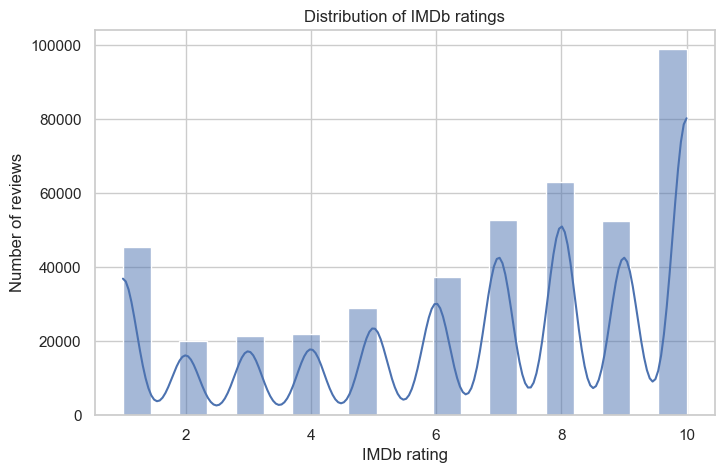

In [36]:
# rating distribution

plt.figure(figsize=(8,5))
sns.histplot(df["rating"], bins=20, kde=True)
plt.xlabel("IMDb rating")
plt.ylabel("Number of reviews")
plt.title("Distribution of IMDb ratings")
plt.show()

### Interpretation

To start things off, we decide to look at the distribution of the ratings compared to the number of reviews. The ratings are on the x-axis, from 1 to 10, while reviews on the y-axis go from 0 to 100,000. From the form of the graph, we notice that it is not a normal distribution, it is quite assymetrical. For our model, predicting an exact rating could be a bit difficult as it is skewed.

What jumps out is the huge peak of reviews at 10. Similarly, there is a concentration of reviews on the ratings between 6 and 9. At the other end, 1 stands out with around 44,000 reviews. There are way less reviews for ratings around the mean, especially the low ratings: 2, 3, 4, and 5. 

We can interpret these observations as users giving mostly either extreme or good ratings with their reviews. There are two scenarios: 1. individuals highly dislike or love a movie and write a review for it; 2. individuals like a movie more than average and decide to write a review worthy of their liking. There seems to be a positivity bias, and reviews are seemingly driven by emotions.

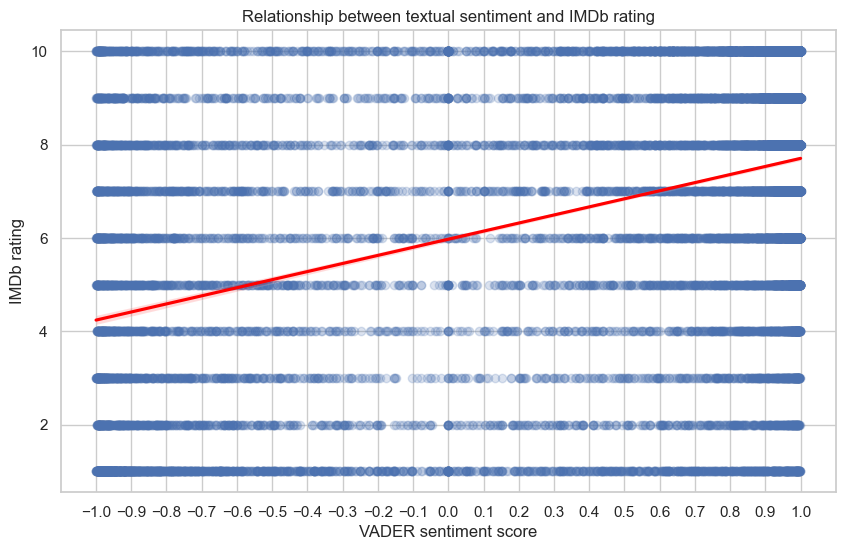

Correlation Coefficient (Pearson) : 0.4328
Correlation Coefficient (Spearman) : 0.3890


In [37]:
# VADER sentiment vs rating

plt.figure(figsize=(10, 6))
sns.regplot(x="sentiment_compound", y="rating", data=df.sample(20000, random_state=42), scatter_kws={"alpha":0.2}, line_kws={"color":"red"})

plt.xticks(np.arange(-1,1.1,0.1))

plt.xlabel("VADER sentiment score")
plt.ylabel("IMDb rating")
plt.title("Relationship between textual sentiment and IMDb rating")
plt.show()

corr_coef = df["sentiment_compound"].corr(df["rating"])
print(f"Correlation Coefficient (Pearson) : {corr_coef:.4f}")

corr_spearman = df["sentiment_compound"].corr(df["rating"], method="spearman")
print(f"Correlation Coefficient (Spearman) : {corr_spearman:.4f}")

### Interpretation

The scatter plot illustrates the relationship between the VADER sentiment compound score (on the x-axis), ranging from -1 to 1 and the IMDb user rating (on the y-axis), ranging from 1 to 10. Every point represents an individual review and the red line represents the fitted linear trend.

The fitted line shows us that there is a positive relationship between the text sentiment score and the IMDb ratings. Which means that reviews with more positive sentiment (higher VADER scores) are associated with higher IMDb ratings and reviews with negative sentiment (lower VADER scores) are associated with lower IMDb ratings. We can also see with the correlation coefficients that there is a moderate positive linear relationship. Indeed, the Pearson coefficient measures the linear relationship between the variables and we got 0.4328 as a result. With the Spearman coefficient, measuring a monotonic relationship, we also get 0.3905 which is close to the Pearson coefficient and confirms its accuracy.

However, we can see that there is a huge dispersion in ratings for a given sentiment score. This may be why the Spearman coefficient is smaller than Pearson: it accounts for extreme values and dispersion. If we look at the graph, we can see that the color is very strong on the extreme ends, which means that the rating is more predictable when the sentiment is extreme. However, when there are nuances, neutral sentiment, or even irony, it is harder to predict the rating, which explains the lesser concentration of observations the more we approach the middle.

In conclusion, the textual content of the reviews is aglined with the rating at large, but it is not that simple as some negative (positive) reviews can give high (low) ratings. It is a good indicator, but not sufficient.

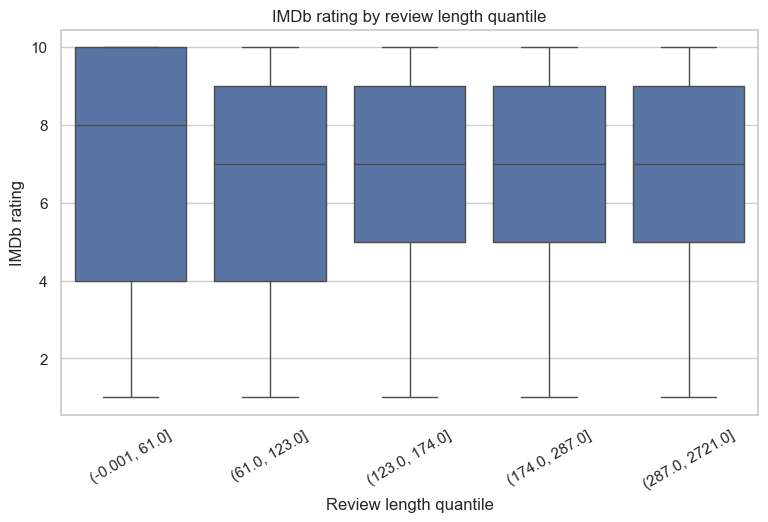

In [38]:
# review length vs rating

df["length_bin"] = pd.qcut(df["review_length_words"], q=5)

plt.figure(figsize=(9,5))
sns.boxplot(x="length_bin", y="rating", data=df)
plt.xticks(rotation=30)
plt.xlabel("Review length quantile")
plt.ylabel("IMDb rating")
plt.title("IMDb rating by review length quantile")
plt.show()

### Interpretation

On the x-axis, we have the length of the reviews with respect to their words, divided into five groups, and on the y-axis, we have the rating from 1 to 10. First, we can say that each group has a minimum of 1 and a maximum of 10 as their rating. The first group contains small reviews, with no more than 61 words. Most of the ratings range from 4 to 10 with a median of 8. Compared to the other groups, it has more extreme values on average, especially opposed to the last three groups, whose range is from 5 to 9. The other groups all have a median of 7. Overall, there is less dispersion in big reviews, starting from 123 words with not much difference compared to reviews of thousands of words.

We can assume that short reviews have more extreme ratings, while longer reviews are probably more critical and offer more restrained ratings.

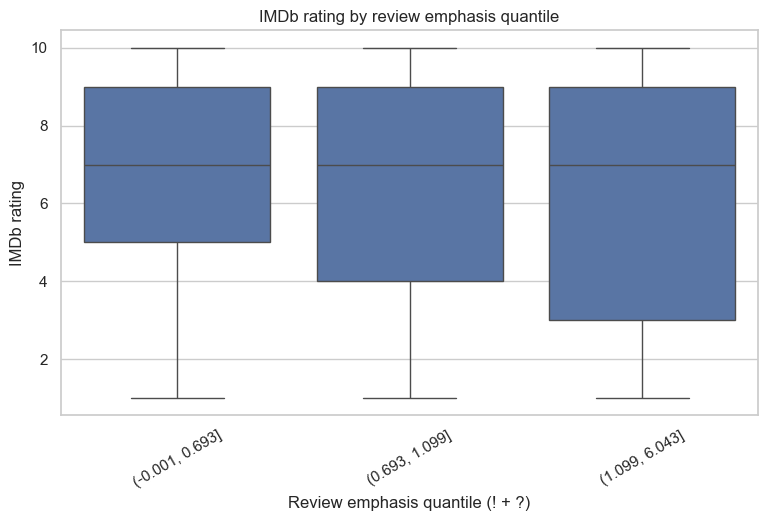

In [39]:
# review emphasis vs rating
df["emphasis_log"] = np.log1p(df["review_emphasis"])
df["emphasis_bin"] = pd.qcut(df["emphasis_log"], q=5, duplicates="drop")
plt.figure(figsize=(9,5))
sns.boxplot(x="emphasis_bin", y="rating", data=df)
plt.xlabel("Review emphasis quantile (! + ?)")
plt.ylabel("IMDb rating")
plt.title("IMDb rating by review emphasis quantile")
plt.xticks(rotation=30)
plt.show()

### Interpretation

On the x-axis, we have the quantiles of the emphasis variables as logarithms, to get a more coherent graph. On the y-axis, we have the rating, from 1 to 10. As we can see, the box increases as we go forward, hence when the emphasis increases. There are more extreme ratings, while the quantiles share the same median. We do not observe any distinction between positive and negative emotions coming out. We can observe intensity, but it is not sufficient to predict the rating as there is no strict delimitation.

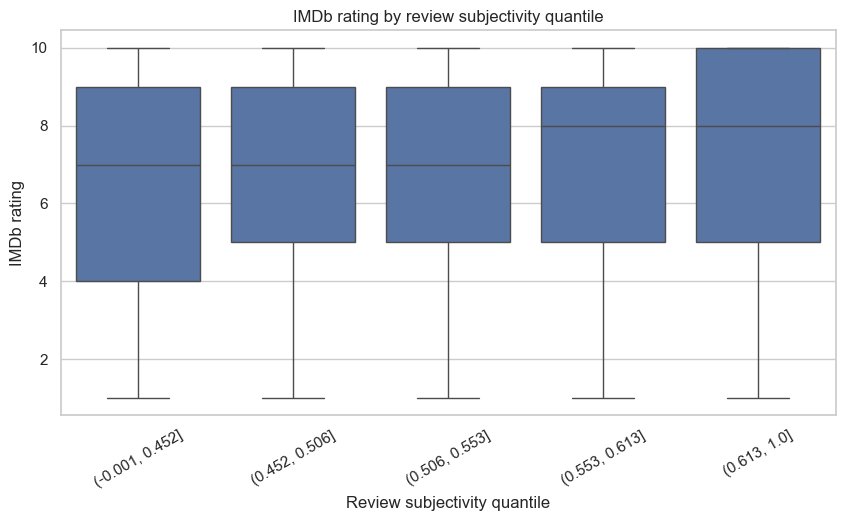

In [40]:
# review subjectivity vs rating
df["subjectivity_bin"] = pd.qcut(df["sentiment_subjectivity"], q=5)
plt.figure(figsize=(10, 5))
sns.boxplot(x="subjectivity_bin", y="rating", data=df)
plt.xlabel("Review subjectivity quantile")
plt.ylabel("IMDb rating")
plt.title("IMDb rating by review subjectivity quantile")
plt.xticks(rotation=30)
plt.show()

### Interpretation

While we have the ratings from 1 to 10 on the y-axis, the x-axis shows the subjectivity quantiles, going from the most factual reviews to the most subjective. There is the same amount of reviews in each quantile as it is evenly divided.

Each quantile presents every rating. This is a slight trend we can notice while looking at the graph, although it is not that big: when subjectivity increases, the median goes up. It begins at 7 until 0.553, and it goes up to 8 in the second half. Likewise, the first quantile (0-0.452) contains most reviews ranging from 4 to 9, while the quantiles from 0.452 to 0.613 range from 5 to 9 for their rating. Lastly, the last quantile has most of its reviews going from 5 to 10.

The trend we notice is that, as subjectivity goes up, the ratings tend to be slightly higher (whether it is overall ratings or the median). However, as it is rather feeble, we cannot say that subjectivity alone explains the rating. We can assume that very subjective reviews tend to be more emotional and in further models, it would be interesting to combine it with sentiment_compound (VADER Sentiment variable) to determine to what degree an emotion is expressed subjectively.

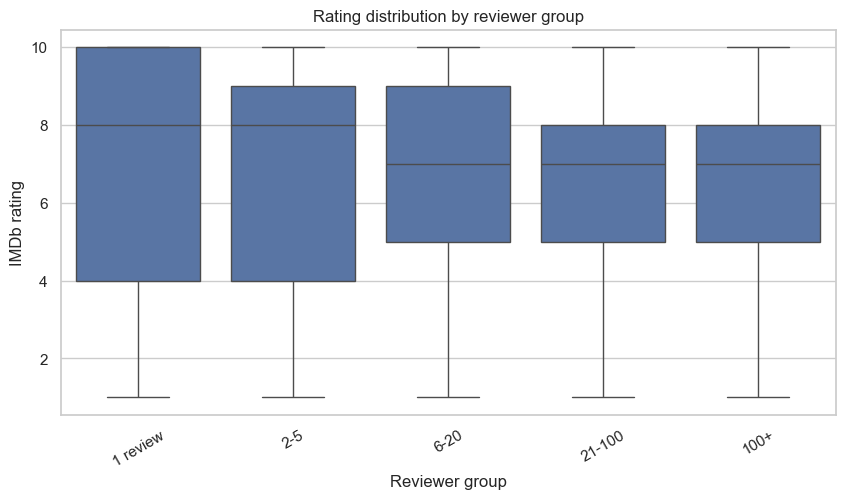

In [41]:
# reviewer group vs rating

plt.figure(figsize=(10,5))
sns.boxplot(x="reviewer_group", y="rating", data=df, order=["1 review","2-5","6-20","21-100","100+"])
plt.xlabel("Reviewer group")
plt.ylabel("IMDb rating")
plt.title("Rating distribution by reviewer group")
plt.xticks(rotation=30)
plt.show()

### Interpretation: 

This boxplot shows the five groups of reviewers and the dispersion of their rating. We can see that every group has a minimum of 1 and a maximum of 10. However, casual reviewers, whose range are from 1 to 5 reviews, have most of their reviews concentrated in the upper part of the scale, starting from 4. The medium group has a narrower box, with most of their reviews going from 5 to 9. Finally, heavy reviewers (from 21 to 100+ reviews) are even more reserved, with most reviews being between 5 and 8. The first group has a median of 8 while the others have a median of 7.

After observing this, we can see that, as we go forward, the box is getting smaller, and the ratings are less extreme on average. We go from 10 being in most of the reviews, to 9, then 8. Inversely, we also go from 4 to 5. We can say that heavy reviewers tend to be more moderate in their ratings, while casual reviewers give more extreme ratings.

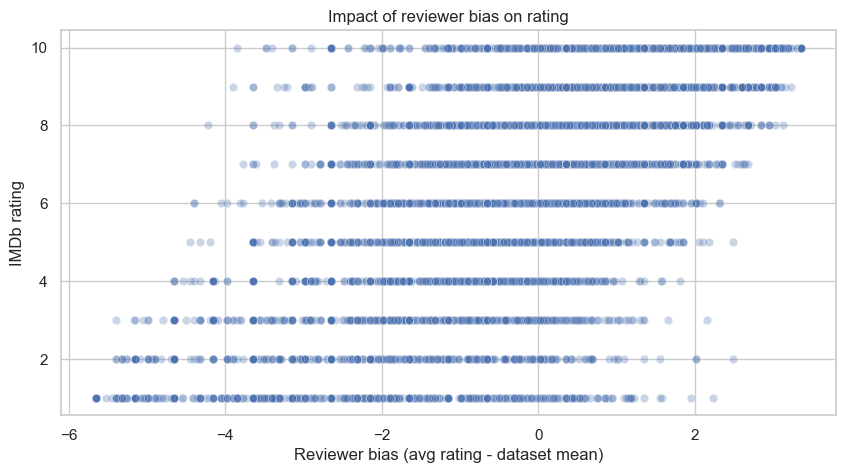

In [42]:
# reviewer bias vs rating

plt.figure(figsize=(10,5))
sns.scatterplot(x="reviewer_bias", y="rating", data=df.sample(20000, random_state=42), alpha=0.3)
plt.xlabel("Reviewer bias (avg rating - dataset mean)")
plt.ylabel("IMDb rating")
plt.title("Impact of reviewer bias on rating")
plt.show()

### Interpretation

On the x-axis, we have the bias of the reviewer. It is computed as average rating of one particular reviewer minus the average rating of the dataset. If it is more on the left of the axis, it means they grade more harshly than average; if they are situated on the right, they have a tendency to "overrate". On the y-axis, we have the rating from 1 to 10.

On the graph, we notice a clear pattern diagonally, indicating a positive relationship between the variables. When the bias is negative, there are more negative ratings, and vice-versa. However, when we look at a single X, we can see multiple ratings: there is a vertical dispersion, which indicates that not everything can be explained with the bias and the rating, the textual content of the review counts for something. The linear relationship is not perfect.

Even though the text is also important, we note that the reviewer's bias (profile) has to be taken into account.

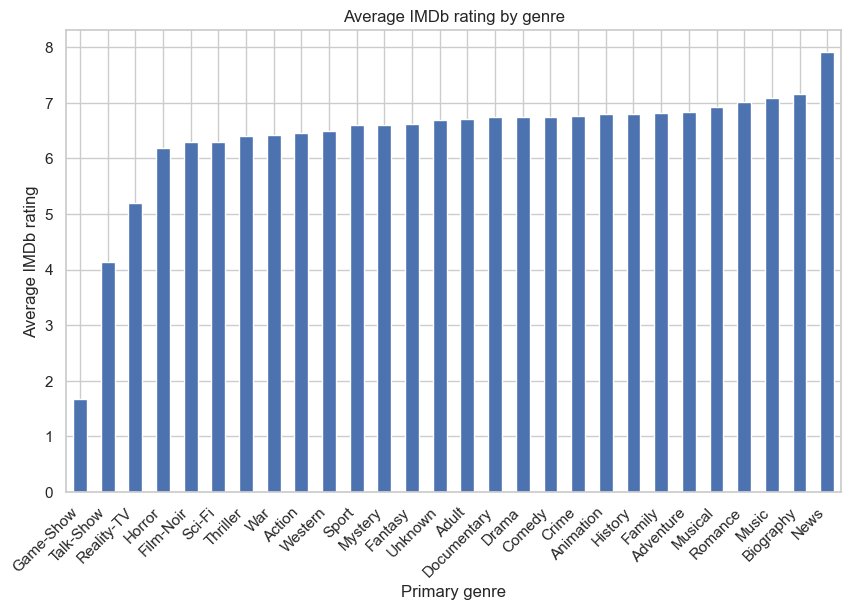

In [43]:
# mean rating per genre
genre_rating = (df.groupby("primary_genre")["rating"].mean().sort_values())

plt.figure(figsize=(10,6))
genre_rating.plot(kind="bar")
plt.ylabel("Average IMDb rating")
plt.xlabel("Primary genre")
plt.title("Average IMDb rating by genre")
plt.xticks(rotation=45, ha="right")
plt.show()

### Interpretation

We are presented with the average IMDb rating on the y-axis and all the primary genres on the x-axis. A vast majority of the genres' average rating are between 6 and 7. Only six genres out of 28 are outside of that range. The ones outside of the average are the genres "Talk Show" and "Game Show", which are less liked, particularly the former with 3.4, and "Romance", "Music", "Biography" and "News", which are slightly above 7.

There are not a lot of differences among the primary genres, so we can assume that while the genre may slightly influence the rating, it is not a strong determinant of the rating of a movie. On its own, it does not affect the rating much.

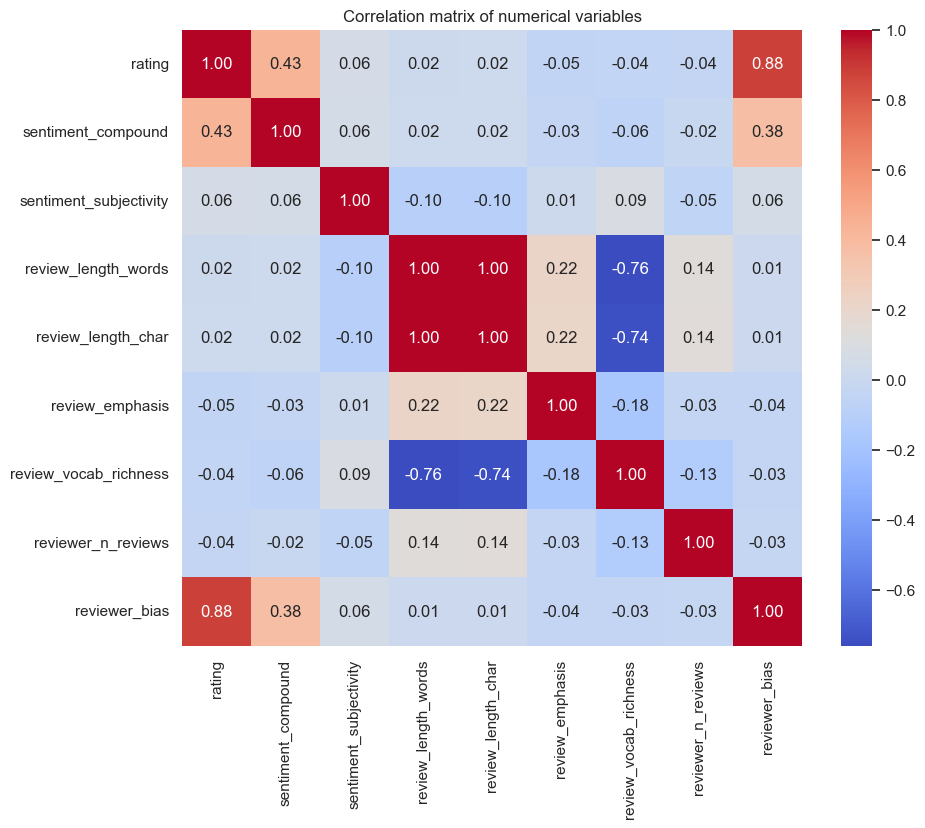

In [44]:
# correlation heatmap

numeric_cols = ["rating", "sentiment_compound", "sentiment_subjectivity", "review_length_words", "review_length_char", "review_emphasis", "review_vocab_richness", "reviewer_n_reviews", "reviewer_bias"]

corr = df[numeric_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix of numerical variables")
plt.show()

### Interpretation

We have created our correlation heatmap containing all our numerical variables. We will now identify useful variables for our model.

First, reviewer_bias is strongly correlated with rating, at 0.88. It has a high explanatory power, which we can use in our model. Then, sentiment_compound is correlated with rating at 0.43, which proves a good relationship. For now, these two had been tested in seen-above graphs and it confirms our conclusions. On the other hand, we have low correlations, notably with subjectivity at 0.06, review_length_words at 0.02, review_emphasis at -0.04, and review_vocab_richness at -0.04. Alone, they do not explain anything as they are more linguistic than anything else.

As for the others, the length of characters and the length of words are exactly the same, so we must keep only one of them; the length of words is negatively correlated to the vocabulary richness by -0.76: the longer the review is, the less it is rich.

------
## Step 4: Modelling

We decided to compute a linear regression and a random forest model using NLP features. In addition to that, we also use a linear regression using TF-IDF features.

1) Linear regression: the goal is to assess whether the sentiment expressed in reviews influence the rating; we will do so by analyzing the coefficients, RMSE, and r².
2) TF-IDF + linear regression: used as a benchmark, TF-IDF captures the raw text and therefore can use the specific expressions used by reviewers, etc.
3) Random forest: this is a non-linear model, it is also used as a benchmark to pick up on complex interactions.

## Linear Regression

Seeing the different variables that we have and the conclusion done from the correlation matrix and the graph, we have decided to do multiple models to test three hypotheses.

- Linear regression (NLP): we only use two main variables first, sentiment_compound (VADER sentiment) and sentiment_subjectivity (TextBlob), and the interaction of those terms. We test the predictability of the text alone thanks to NLP used above.
- Linear regression (NLP + metadata): we add the variables movie_age, averageRating, numVotes, and primary_genre, to test if the context surrounding the movie helps preidction.
- Linear regression (NLP + metadata + reviewer): we add the final variables - reviewer_bias, reviewer_n_reviews, reviewer_group. We finally test the impact of the reviewer behavior.

In [45]:
# Creating an interaction variable, the "results" list to compare results at the end, and the commun train_test split
df["subjectivity_x_sentiment"] = (df["sentiment_subjectivity"] * df["sentiment_compound"])
results = []

df_base = df.dropna(subset=["rating"])
train_df, test_df = train_test_split(df_base, test_size=0.2, random_state=42)

In [46]:
# Selecting variables
num_features_1 = ["sentiment_compound", "sentiment_subjectivity", "subjectivity_x_sentiment"]

# Drop missing values
train_df1 = train_df.dropna(subset=num_features_1)
test_df1 = test_df.dropna(subset=num_features_1)

In [47]:
# Train-test

X_train1 = train_df1[num_features_1]
y_train1 = train_df1["rating"]

X_test1 = test_df1[num_features_1]
y_test1 = test_df1["rating"]

In [48]:
# Pipeline
process1 = ColumnTransformer([("num", StandardScaler(), num_features_1)])
model1 = Pipeline([("process", process1), ("lr", LinearRegression())])

# Fit
model1.fit(X_train1, y_train1)

Pipeline(steps=[('process',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['sentiment_compound',
                                                   'sentiment_subjectivity',
                                                   'subjectivity_x_sentiment'])])),
                ('lr', LinearRegression())])

In [49]:
# Prediction
y_pred1 = model1.predict(X_test1)

# Adding results to the list
results.append({
    "Model": "Simple Linear Regression (1)",
    "RMSE": np.sqrt(mean_squared_error(y_test1, y_pred1)),
    "R2": r2_score(y_test1, y_pred1)
})

### Second model

In [50]:
# Selecting variables
num_features_2 = ["sentiment_compound", "sentiment_subjectivity", "subjectivity_x_sentiment", "movie_age", "averageRating", "numVotes"]
cat_features_2 = ["primary_genre"]

# Drop missing values
train_df2 = train_df.dropna(subset=num_features_2 + cat_features_2)
test_df2 = test_df.dropna(subset=num_features_2 + cat_features_2)

In [51]:
# Train-test

X_train2 = train_df2[num_features_2 + cat_features_2]
y_train2 = train_df2["rating"]

X_test2 = test_df2[num_features_2 + cat_features_2]
y_test2 = test_df2["rating"]

We have two types of features: numerical and categorical. In order to compute them in the model, we need to convert the categorical values to numbers. For it to work, we use OneHotEncoder, which transforms string into binary columns, and ColumnTransformer, which processes the two different processes (StandardScaler and OneHotEncoder) in a single way. StandardScaler handles the numerical values without having to add anything.

In [52]:
# Pipeline
process2 = ColumnTransformer([("num", StandardScaler(), num_features_2), ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features_2)])
model2 = Pipeline([("process", process2), ("lr", LinearRegression())])

# Fit
model2.fit(X_train2, y_train2)

Pipeline(steps=[('process',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['sentiment_compound',
                                                   'sentiment_subjectivity',
                                                   'subjectivity_x_sentiment',
                                                   'movie_age', 'averageRating',
                                                   'numVotes']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['primary_genre'])])),
                ('lr', LinearRegression())])

In [53]:
# Prediction
y_pred2 = model2.predict(X_test2)

# Adding results to the list
results.append({
    "Model": "Model with metadata (2)",
    "RMSE": np.sqrt(mean_squared_error(y_test2, y_pred2)),
    "R2": r2_score(y_test2, y_pred2)
})

### Third model

In [54]:
# Selecting numerical and categorical features
num_features_3 = ["sentiment_compound", "sentiment_subjectivity", "subjectivity_x_sentiment", "reviewer_bias", "reviewer_n_reviews", "movie_age", "averageRating", "numVotes"]
cat_features_3 = ["primary_genre", "reviewer_group"]

# Dropping rows with missing values
train_df3 = train_df.dropna(subset=num_features_3 + cat_features_3)
test_df3 = test_df.dropna(subset=num_features_3 + cat_features_3)

In [55]:
# Train-test

X_train3 = train_df3[num_features_3 + cat_features_3]
y_train3 = train_df3["rating"]

X_test3 = test_df3[num_features_3 + cat_features_3]
y_test3 = test_df3["rating"]

In [56]:
# Pipeline
process3 = ColumnTransformer([("num", StandardScaler(), num_features_3), ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features_3)])
model3 = Pipeline([("process", process3), ("lr", LinearRegression())])

# Fit
model3.fit(X_train3, y_train3)

Pipeline(steps=[('process',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['sentiment_compound',
                                                   'sentiment_subjectivity',
                                                   'subjectivity_x_sentiment',
                                                   'reviewer_bias',
                                                   'reviewer_n_reviews',
                                                   'movie_age', 'averageRating',
                                                   'numVotes']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['primary_genre',
                                                   'reviewer_group'])])),
                ('lr', LinearRegression())])

In [57]:
# Prediction
y_pred3 = model3.predict(X_test3)

# Adding results to the list
results.append({
    "Model": "Final model with metadata and review features (3)",
    "RMSE": np.sqrt(mean_squared_error(y_test3, y_pred3)),
    "R2": r2_score(y_test3, y_pred3)
})

In [58]:
# in order to associate each name with the coefficients, we go over each variable in the list
# .named_ is a dictionary, we get access to the names of the categorical columns with _steps and _transformers

coefficients = pd.Series(
    model3.named_steps["lr"].coef_,
    index=num_features_3 + list(model3.named_steps["process"].named_transformers_["cat"].get_feature_names_out(cat_features_3))
).sort_values()

coefficients

primary_genre_Music         -0.158302
primary_genre_Comedy        -0.113680
primary_genre_Action        -0.084706
primary_genre_Adventure     -0.080211
primary_genre_Adult         -0.076383
primary_genre_Musical       -0.075423
primary_genre_Documentary   -0.055525
primary_genre_Film-Noir     -0.055253
primary_genre_Fantasy       -0.048215
primary_genre_Horror        -0.045116
primary_genre_Romance       -0.040685
primary_genre_Mystery       -0.036947
primary_genre_Animation     -0.034765
primary_genre_Drama         -0.030583
primary_genre_Unknown       -0.022988
reviewer_group_6-20         -0.009158
reviewer_group_21-100       -0.005003
sentiment_subjectivity      -0.003969
reviewer_n_reviews          -0.002360
primary_genre_Reality-TV     0.000414
reviewer_group_1 review      0.001728
reviewer_group_2-5           0.002464
numVotes                     0.009596
reviewer_group_100+          0.009969
primary_genre_Thriller       0.012895
movie_age                    0.013062
primary_genr

### Comparative table

We added every result to a list, now including three dictionaries. This approach was made in order to compare directly the results with one another, and see if the added features in model 3 are useful or not.

In [59]:
results_df = pd.DataFrame(results)
results_df

,Model,RMSE,R2
0,Simple Linear Regression (1),2.673177,0.196437
1,Model with metadata (2),2.642792,0.212481
2,Final model with metadata and review features (3),1.408741,0.776232


### Interpretation

Firstly, let's explain what RMSE (Root Mean Squared Error) and r² (Goodness of Fit) explain.
1) RMSE explians the average magnitude of the error; in our case, by how many points the model misjudges the IMDb rating (out of 10). The lower it is, the better.
2) R² is the goodness of it, it gives the proportion of the variance in ratings that is explained by the model.

**The first model uses only textual variables**: are the sentiment and subjectivity of the text enough to explain the rating? We can see that the model's prediction is 2.7 points off and it only explains about 19.6% of the model. Consequently, it only has a slight explanatory power.

**The second model uses textual variables and metadata from IMDb**: the results are almost the same, it explains the model a bit more by +1.6% and the prediction is better by 0.3 points.

**The third model uses reviewer data, in addition to textual and metadata variables**: we notice a huge increase in the data. The model's prediction improved by 0.8 points, which means the prediction is 1.4 points off. The proportion explained by the model is ~77%. 

To conclude, we can safely state that reviewer data is a major explanatory variable explaining the rating. While the text is important, who writes the reviews matters even more.


### Coefficients

The strongest variable is *reviewer_bias* (+2.45): for the same movie and text, a reviewer whose mean is 1 point above the dataset mean will give 2.45 points more on his predicted rating.

If we look at the interaction term we created, *subjectivity_x_sentiment* has a coefficient of +0.29. It's positive and it expresses that a subjective positive sentiment will increase the rating, and vice-versa.

*Sentiment_subjectivity* alone is negative and extremely scarce, which makes it not informative on its own as shown by the seen-above graph.

Overall, *reviewer group* for every group has very scarce coefficients (moderate effect), so it is not as important as reviewer_bias.

As for *genres*, some genres receive on average higher ratings, such as War and Sport, while other genres receive on average lower ratings, like Comedy or Horror. However, this variable captures viewer expectations rather than quality.

-------------
## TF-IDF & Linear Regression

This linear regression model uses a TF-IDF representation of the text as input to predict the IMDb ratings, hence it analyzes the importance level of the words.

In [60]:
# Vectorization

tfidf = TfidfVectorizer(max_features=5000, min_df=5, stop_words="english")

X_train_text = tfidf.fit_transform(train_df["review_detail_clean"])
X_test_text = tfidf.transform(test_df["review_detail_clean"])

y_train = train_df["rating"]
y_test = test_df["rating"]

In [61]:
# Estimating the model with the linear regression

tfidf_lr = LinearRegression()
tfidf_lr.fit(X_train_text, y_train)

LinearRegression()

In [62]:
# Prediction and evaluation

y_pred_tfidf = tfidf_lr.predict(X_test_text)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_tfidf))
r2 = r2_score(y_test, y_pred_tfidf)

print("TF-IDF + Linear Regression")
print("RMSE:", rmse)
print("R²:", r2)

TF-IDF + Linear Regression
RMSE: 1.975070808717298
R²: 0.5613381763242378


In [63]:
# Interpretation of the words

feature_names = np.array(tfidf.get_feature_names_out())
coefs = tfidf_lr.coef_

top_positive = pd.Series(coefs, index=feature_names).sort_values(ascending=False).head(20)
top_negative = pd.Series(coefs, index=feature_names).sort_values().head(20)

print("Top positive words influencing rating:")
print(top_positive)
print("\nTop negative words influencing rating:")
print(top_negative)

Top positive words influencing rating:
best           4.688199
excellent      4.471692
great          4.258627
loved          4.164188
amazing        4.136191
1010           4.038855
perfect        4.006590
brilliant      3.977481
complaining    3.860828
awesome        3.761828
mustsee        3.665087
favorite       3.577397
refreshing     3.565469
greatest       3.505093
superb         3.444820
funniest       3.403276
masterpiece    3.380089
phenomenal     3.306235
complain       3.298656
910            3.275379
dtype: float64

Top negative words influencing rating:
worst            -8.598255
waste            -7.023800
insult           -7.016307
awful            -5.733830
insulting        -5.658402
wasted           -5.513756
garbage          -5.493941
horrible         -5.300045
dreadful         -5.147428
unwatchable      -5.118013
unfunny          -5.086884
boring           -5.049263
terrible         -5.017629
redeeming        -4.984167
disappointment   -4.920317
poorly           -4.9

## Random Forest

Random Forest is a non-linear program, used to capture potential non-linear relationships that could not be portrayed in earlier models.

In [64]:
# Selecting features
rf_features = ["sentiment_compound", "sentiment_subjectivity", "subjectivity_x_sentiment", "reviewer_bias", "reviewer_n_reviews", "movie_age", "averageRating", "numVotes"]

# Dropping missing values
train_df_rf = train_df.dropna(subset=rf_features + ["rating"])
test_df_rf = test_df.dropna(subset=rf_features + ["rating"])

In [65]:
# Train-test split
X_train_rf = train_df_rf[rf_features]
y_train_rf = train_df_rf["rating"]

X_test_rf = test_df_rf[rf_features]
y_test_rf = test_df_rf["rating"]

rf = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=42, n_jobs=-1)

In [66]:
# Fit
rf.fit(X_train_rf, y_train_rf)

# Prediction
y_pred_rf = rf.predict(X_test_rf)

In [69]:
# Evaluation
rmse = np.sqrt(mean_squared_error(y_test_rf, y_pred_rf))
r2 = r2_score(y_test_rf, y_pred_rf)

print("Random Forest")
print("RMSE:", rmse)
print("R²:", r2)

Random Forest
RMSE: 1.3481632396459788
R²: 0.7950632517655158


In [70]:
# Feature importance

importances = pd.Series(rf.feature_importances_, index=rf_features).sort_values(ascending=False)

print(importances)

reviewer_bias               0.785908
sentiment_compound          0.045906
numVotes                    0.033874
subjectivity_x_sentiment    0.029037
averageRating               0.027116
sentiment_subjectivity      0.027087
reviewer_n_reviews          0.025800
movie_age                   0.025274
dtype: float64


### Interpretation & Comparison

- The model Linear Regression with TF-IDF has an RMSE of 1.975 and an r² of 0.56. 

The variance in ratings is explained by 56%, and the model's prediction of the rating is off by 1.98 points. We see that this model is better than the first two linear regressions with only NLP and with the metadata. It captures the specific words of the textual reviews. However, it is still less efficient than the model including reviewer data. It needs context.

Regarding the top positive and negative words, the result is extremely coherent and there is a visible emotional polarity. The model answers to which words influence the rating, more than who rates what and how (unlike the other models).


- The model Random Forest has an RMSE of 1.35 and an r² of 0.795.

RF explains 56% of the variance in movie ratings while its prediction is off by 1.35 points. This is the best model so far: it doesn't suppose a linear relationship comprises complex interactions. Compared to the final linear regression, this is a moderate gain made.

Considering feature importances, which indicate the relative contriution of each variation in the error reduction, reviewer_bias has the most importance: it is dominant and presents an importance of 79%. 

*Note: feature importances could be biased in favor of continuous variables, which contain a lot of distinct variables. This could in part influence the dominance of reviewer_bias.*

----------
# Discussion and conclusion

To answer our initial question, prediction ratings depends on the content as much as the reviewer. The context is essential as the text only is limited in its predictability. The results show that while textual sentiment extracted from reviews contributes to predicting IMDb ratings, they are not sufficient to accurately predict IMDb ratings on their own. Including reviewer-related features substantially improves performance, which highlights the importance of individual rating behavior.

The reviewer’s personal rating tendency is by far the strongest predictor of the given rating. Some reviewers rate higher (driven by emotion), others are more severe (more critical), and the model determines who rates in what way independently of the movie. We have observed that casual reviewers correspond to the first category while heavy reviewers belong to the second category.

As for the models:

- The TF-IDF captures word-level sentiment and shows the text is clearly informative and influence the rating, however it is not sufficient as the behavior of the reviewer dominates.
- The Random Forest model confirms that reviewer-related features largely drive rating prediction, while textual sentiment and movie metadata has a complementary role.
- The Linear Regression model highlights interpretable effects, particularly the strong influence of reviewer bias and the interaction between sentiment polarity and subjectivity.


Among all models, the Random Forest regressor achieves the best predictive accuracy, suggesting the presence of non-linear relationships and complex interactions between reviewer behavior and textual features. While it has the best performance, the Linear Rgression however has the best compromise between interpretability and performance. (RF has no direction represented by a sign, no marginal effect as there is no equation.)